In [1]:
#default_exp anime.dataloader

In [2]:
!pip install wandb --upgrade

Requirement already up-to-date: wandb in /home/fast/anaconda3/envs/fastai2/lib/python3.6/site-packages (0.8.36)


In [1]:
from ../selfie2anime.anime.dataloading import *

ModuleNotFoundError: No module named 'anime'

In [4]:
#export
import pandas as pd
from pathlib import Path
import json
from functools import partial
from PIL import Image
import numpy as np
from itertools import chain
from fastai2.torch_basics import *
from fastai2.layers import *
from fastai2.data.all import *
from fastai2.data.block import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from anime.ugatit import *
from fastai2.callback.wandb import WandbCallback
import wandb
from fastai2.fp16_utils import convert_module
from anime.ugatit_networks import ILN,adaILN
from fastai2.callback.fp16 import _copy_state
from torch.autograd import Variable
from anime.callbacks import *
import gc
import math

In [5]:
lr=0.0001
wd=0.01
img_size=256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


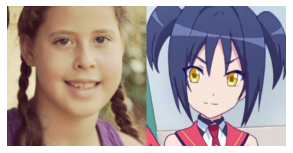

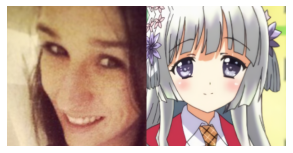

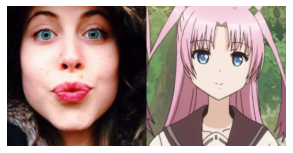

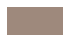

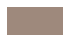

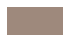

In [6]:
dls=UGATITData().create_ugatit_dls()
dls.show_batch()

In [7]:
ugatit=UGATIT(bce=False)
ugatit.img_size=img_size
ugatit.build_model()

In [8]:
gen_loss=Conditional_Loss(lambda learn: not learn.disc_pass, name='Gloss_Metric')
disc_loss=Conditional_Loss(lambda learn: learn.disc_pass, name='Dloss_Metric')
model=UgatitModel(ugatit.models,devices=[torch.device(type='cuda', index=0),torch.device(type='cuda', index=1)])
model=convert_network(model, dtype=torch.float16)
learner=Learner(dls,model,UGATITLoss(cycle_weight = 10,identity_weight = 10,cam_weight = 1000,adv_weight=1,bce=False).losses,partial(GANOptimizer,zero_Adam,zero_Adam,wd=wd),lr,splitter=GAN_splitter,metrics=[gen_loss,disc_loss])
learner.add_cbs(L([Switch(),LinearDecreaseLR(),SameXbYb()]))
learner.add_cb(MetricRecorder())
learner.recorder.train_metrics=True

Try using just the generator, discriminator, and pre-trained GAN output. Loss function would be adverserial loss + MSE-ish loss with pre-trained GANs output. LR would have to decrease overtime and/or wight between adv loss and MSE loss would need to be more adverserial. 

In [9]:
MixedPrecisionTupleNo32??

In [10]:
learner.add_cbs((ModelToHalfAdaLIN(),MixedPrecisionTupleNo32(gdiv_factor=2,dynamic=True,multi_loss=True,loss_scale=1.),))#, max_loss_scale=((2 - 2**-23) * 2**127))

In [11]:
learner.show_training_loop()

Start Fit
   - begin_fit      : [LinearDecreaseLR, TrainEvalCallback, Recorder, ProgressCallback, MixedPrecisionTupleNo32]
  Start Epoch Loop
     - begin_epoch    : [Recorder, ProgressCallback, Switch]
    Start Train
       - begin_train    : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - begin_batch    : [LinearDecreaseLR, SameXbYb, ModelToHalfAdaLIN, Switch, MixedPrecisionTupleNo32]
         - after_pred     : [SameXbYb, MixedPrecisionTupleNo32]
         - after_loss     : [MixedPrecisionTupleNo32]
         - after_backward : [MixedPrecisionTupleNo32]
         - after_step     : [MixedPrecisionTupleNo32]
         - after_cancel_batch: []
         - after_batch    : [MetricRecorder, TrainEvalCallback, Recorder, ProgressCallback, Switch]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - begin_validate : [TrainEvalCallback, Recorder, ProgressCallback]

In [12]:
#learner.load('ugatitcrash2_180',with_opt=True)

###### wandb has to be called in same cell when model is split across multiple GPUs
wandb.init()
learner.add_cbs([GANWandb(valid_dl=learner.dls.valid),SaveModelCallback(fname='ugatitcrash4')])
learner.fit(20,wd=wd,lr=lr)

In [13]:
wandb.init() #wandb must be added in same cell due to bug
learner.add_cb(GANWandb(valid_dl=learner.dls.valid))
learner.fit(20,wd=wd,lr=lr)

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.weight', torch.Size([256, 512, 1, 1])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.gamma.weight', torch.Size([256, 256])), ('models.GA2B.beta.weight', torch.Size([256, 256])), ('models.GA2B.UpBlock1_1.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_1.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_1.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm1.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_2.conv2.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_2.norm2.rho', torch.Size([1, 256, 1, 1])), ('models.GA2B.UpBlock1_3.conv1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.UpBlock1_3.norm1.rho', torch.Size([1, 256,

[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.gmp_fc.weight', torch.Size([2, 256])), ('models.GA2B.conv1x1.bias', torch.Size([256])), ('models.GA2B.FC0.splits.0.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.1.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.2.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.3.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.4.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.5.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.6.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.7.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.8.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.9.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.10.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.11.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.splits.12.weight', torch.Size([8, 1048576])), ('models.GA2B.FC0.spli

[('models.GB2A.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gmp_fc.weight', torch.Size([2, 256])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.GB2A.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gmp_fc.weight', torch.Size([2, 256])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 

[('models.DA.gap_fc.weight_orig', torch.Size([1, 2048])), ('models.DA.gmp_fc.weight_orig', torch.Size([1, 2048])), ('models.DA.conv1x1.bias', torch.Size([2048])), ('models.DA.conv.weight_orig', torch.Size([1, 2048, 4, 4])), ('models.DA.model.1.bias', torch.Size([64])), ('models.DA.model.1.weight_orig', torch.Size([64, 3, 4, 4])), ('models.DA.model.4.bias', torch.Size([128])), ('models.DA.model.4.weight_orig', torch.Size([128, 64, 4, 4])), ('models.DA.model.7.bias', torch.Size([256])), ('models.DA.model.7.weight_orig', torch.Size([256, 128, 4, 4])), ('models.DA.model.10.bias', torch.Size([512])), ('models.DA.model.10.weight_orig', torch.Size([512, 256, 4, 4])), ('models.DA.model.13.bias', torch.Size([1024])), ('models.DA.model.13.weight_orig', torch.Size([1024, 512, 4, 4])), ('models.DA.model.16.bias', torch.Size([2048])), ('models.DA.model.16.weight_orig', torch.Size([2048, 1024, 4, 4])), ('models.DB.gap_fc.weight_orig', torch.Size([1, 2048])), ('models.DB.gmp_fc.weight_orig', torch.Si

[('models.DA.gap_fc.weight_orig', torch.Size([1, 2048])), ('models.DA.gmp_fc.weight_orig', torch.Size([1, 2048])), ('models.DA.model.1.bias', torch.Size([64])), ('models.DA.model.1.weight_orig', torch.Size([64, 3, 4, 4])), ('models.DA.model.4.bias', torch.Size([128])), ('models.DA.model.4.weight_orig', torch.Size([128, 64, 4, 4])), ('models.DA.model.7.bias', torch.Size([256])), ('models.DA.model.7.weight_orig', torch.Size([256, 128, 4, 4])), ('models.DA.model.10.bias', torch.Size([512])), ('models.DA.model.10.weight_orig', torch.Size([512, 256, 4, 4])), ('models.DA.model.13.bias', torch.Size([1024])), ('models.DA.model.13.weight_orig', torch.Size([1024, 512, 4, 4])), ('models.DA.model.16.bias', torch.Size([2048])), ('models.DA.model.16.weight_orig', torch.Size([2048, 1024, 4, 4])), ('models.DB.gap_fc.weight_orig', torch.Size([1, 2048])), ('models.DB.gmp_fc.weight_orig', torch.Size([1, 2048])), ('models.DB.model.1.bias', torch.Size([64])), ('models.DB.model.1.weight_orig', torch.Size([6

/home/fast/anaconda3/envs/fastai2/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/fast/fastai2/fastai2/fastai2/callback/core.py:28: UserWarning: You are setting an attribute (loss_func) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.loss_func` if you would like to change it in the learner.
  warn(f"You are setting an attribute ({name}) that also exists in the learner. Please be advised that you're not setting it in the learner but in the callback. Use `self.learn.{name}` if you would like to change it in the learner.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for i

[('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.DA.model.16.weight_orig', torch.Size([2048, 1024, 4, 4]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GB2A.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.bias', torch.Size([64]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.bias', torch.Size([64]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.LB.model.1.bias', torch.Size([64]))]
[('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LA.gmp_fc.weight_orig', torch.Size([1, 512]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.bias', torch.Size([64])), ('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3]))]
[('models.LB.model.1.bias', torch.Siz

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.bias', torch.Size([64]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.bias', torch.Size([64]))]


requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream. args: ('https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1041, 'content': ['{"system.gpu.0.gpu": 49.4, "system.gpu.0.memory": 18.07, "system.gpu.0.memoryAllocated": 69.05, "system.gpu.0.temp": 81.4, "system.gpu.0.powerWatts": 104.16, "system.gpu.0.powerPercent": 83.32, "system.gpu.1.gpu": 50.33, "system.gpu.1.memory": 18.73, "system.gpu.1.memoryAllocated": 68.85, "system.gpu.1.temp": 68.67, "system.gpu.1.powerWatts": 87.5, "system.gpu.1.powerPercent": 83.34, "system.cpu": 38.11, "system.memory": 37.95, "system.disk": 83.4, "system.proc.memory.availableMB": 19976.94, "system.proc.memory.rssMB": 8280.84, "system.proc.memory.percent": 25.73, "system.proc.cpu.threads": 50.0, "system.network.sent": 924494262, "system.network.recv": 44874528

requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream. args: ('https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1041, 'content': ['{"system.gpu.0.gpu": 49.4, "system.gpu.0.memory": 18.07, "system.gpu.0.memoryAllocated": 69.05, "system.gpu.0.temp": 81.4, "system.gpu.0.powerWatts": 104.16, "system.gpu.0.powerPercent": 83.32, "system.gpu.1.gpu": 50.33, "system.gpu.1.memory": 18.73, "system.gpu.1.memoryAllocated": 68.85, "system.gpu.1.temp": 68.67, "system.gpu.1.powerWatts": 87.5, "system.gpu.1.powerPercent": 83.34, "system.cpu": 38.11, "system.memory": 37.95, "system.disk": 83.4, "system.proc.memory.availableMB": 19976.94, "system.proc.memory.rssMB": 8280.84, "system.proc.memory.percent": 25.73, "system.proc.cpu.threads": 50.0, "system.network.sent": 924494262, "system.network.recv": 44874528

requests_with_retry encountered retryable exception: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')). args: ('https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1041, 'content': ['{"system.gpu.0.gpu": 49.4, "system.gpu.0.memory": 18.07, "system.gpu.0.memoryAllocated": 69.05, "system.gpu.0.temp": 81.4, "system.gpu.0.powerWatts": 104.16, "system.gpu.0.powerPercent": 83.32, "system.gpu.1.gpu": 50.33, "system.gpu.1.memory": 18.73, "system.gpu.1.memoryAllocated": 68.85, "system.gpu.1.temp": 68.67, "system.gpu.1.powerWatts": 87.5, "system.gpu.1.powerPercent": 83.34, "system.cpu": 38.11, "system.memory": 37.95, "system.disk": 83.4, "system.proc.memory.availableMB": 19976.94, "system.proc.memory.rssMB": 8280.84, "system.proc.memory.percent": 25.73, "system.proc.cpu.threads": 50.0, "system.network.sent": 924494262, "system.network.recv": 448745281, "_wandb": true, "_timestamp": 1590219371, "_runtime": 

requests_with_retry encountered retryable exception: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')). args: ('https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1041, 'content': ['{"system.gpu.0.gpu": 49.4, "system.gpu.0.memory": 18.07, "system.gpu.0.memoryAllocated": 69.05, "system.gpu.0.temp": 81.4, "system.gpu.0.powerWatts": 104.16, "system.gpu.0.powerPercent": 83.32, "system.gpu.1.gpu": 50.33, "system.gpu.1.memory": 18.73, "system.gpu.1.memoryAllocated": 68.85, "system.gpu.1.temp": 68.67, "system.gpu.1.powerWatts": 87.5, "system.gpu.1.powerPercent": 83.34, "system.cpu": 38.11, "system.memory": 37.95, "system.disk": 83.4, "system.proc.memory.availableMB": 19976.94, "system.proc.memory.rssMB": 8280.84, "system.proc.memory.percent": 25.73, "system.proc.cpu.threads": 50.0, "system.network.sent": 924494262, "system.network.recv": 448745281, "_wandb": true, "_timestamp": 1590219371, "_runtime": 

requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream. args: ('https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1041, 'content': ['{"system.gpu.0.gpu": 49.4, "system.gpu.0.memory": 18.07, "system.gpu.0.memoryAllocated": 69.05, "system.gpu.0.temp": 81.4, "system.gpu.0.powerWatts": 104.16, "system.gpu.0.powerPercent": 83.32, "system.gpu.1.gpu": 50.33, "system.gpu.1.memory": 18.73, "system.gpu.1.memoryAllocated": 68.85, "system.gpu.1.temp": 68.67, "system.gpu.1.powerWatts": 87.5, "system.gpu.1.powerPercent": 83.34, "system.cpu": 38.11, "system.memory": 37.95, "system.disk": 83.4, "system.proc.memory.availableMB": 19976.94, "system.proc.memory.rssMB": 8280.84, "system.proc.memory.percent": 25.73, "system.proc.cpu.threads": 50.0, "system.network.sent": 924494262, "system.network.recv": 44874528

requests_with_retry encountered retryable exception: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')). args: ('https://api.wandb.ai/files/marii/uncategorized/1t94ay48/file_stream',), kwargs: {'json': {'files': {'wandb-events.jsonl': {'offset': 1041, 'content': ['{"system.gpu.0.gpu": 49.4, "system.gpu.0.memory": 18.07, "system.gpu.0.memoryAllocated": 69.05, "system.gpu.0.temp": 81.4, "system.gpu.0.powerWatts": 104.16, "system.gpu.0.powerPercent": 83.32, "system.gpu.1.gpu": 50.33, "system.gpu.1.memory": 18.73, "system.gpu.1.memoryAllocated": 68.85, "system.gpu.1.temp": 68.67, "system.gpu.1.powerWatts": 87.5, "system.gpu.1.powerPercent": 83.34, "system.cpu": 38.11, "system.memory": 37.95, "system.disk": 83.4, "system.proc.memory.availableMB": 19976.94, "system.proc.memory.rssMB": 8280.84, "system.proc.memory.percent": 25.73, "system.proc.cpu.threads": 50.0, "system.network.sent": 924494262, "system.network.recv": 448745281, "_wandb": true, "_timestamp": 1590219371, "_runtime": 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.bias', torch.Size([64])), ('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.bias', torch.Size([64]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GA2B.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.11.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.12.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GA2B.DownBlock.13.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.DownBlock.10.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.10.conv_block.5.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A.DownBlock.11.conv_block.1.weight', torch.Size([256, 256, 3, 3])), ('models.GB2A

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.bias', torch.Size([64])), ('models.LB.model.4.bias', torch.Size([128]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.LB.model.1.bias', torch.Size([64])), ('models.LB.model.4.bias', torch.Size([128]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GA2B.gap_fc.weight', torch.Size([2, 256])), ('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]
[('models.GB2A.gap_fc.weight', torch.Size([2, 256]))]
[('models.LB.model.1.weight_orig', torch.Size([64, 3, 4, 4]))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


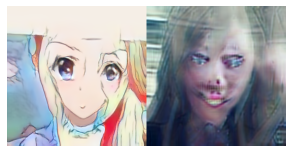

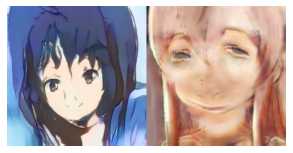

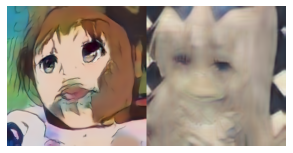

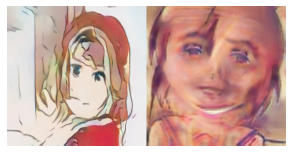

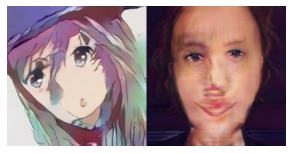

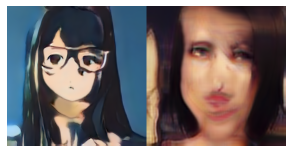

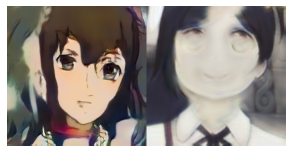

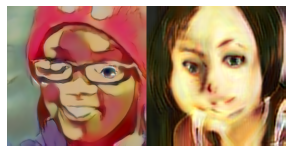

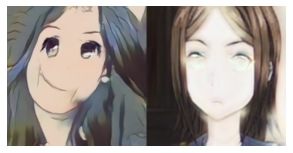

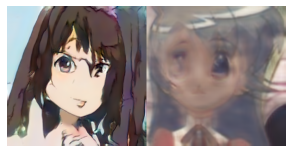

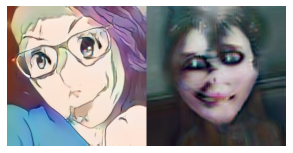

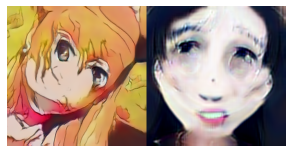

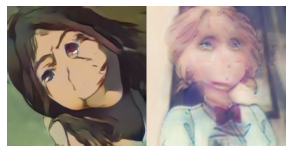

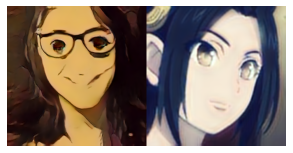

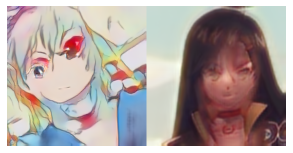

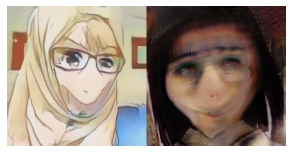

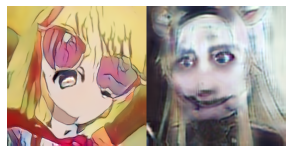

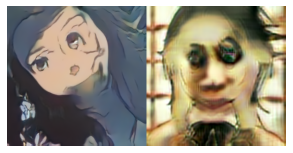

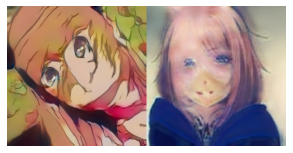

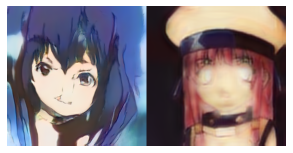

In [14]:
for i in range(20):
    learner.show_results()

In [1]:
Adam??

Object `Adam` not found.
